## EDA & Data cleaning

In this notebook, we have used NLP techniques to clean up our dataset (removed stop words and punctuation and lemmatized each review) in order to prepare the data for classification algorithms.  

In [ ]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import json
import string
import spacy
import nltk
from nltk.corpus import stopwords
from  nltk import FreqDist
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# load json file and put into a df
data = [json.loads(line) for line in open('../reviews_Electronics_5.json', 'r')]
df = pd.DataFrame(data)

In [20]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0528881469,"[0, 0]",5.0,We got this GPS for my husband who is an (OTR)...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1370131200
1,0528881469,"[12, 15]",1.0,"I'm a professional OTR truck driver, and I bou...","11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200
2,0528881469,"[43, 45]",3.0,"Well, what can I say. I've had this unit in m...","09 9, 2010",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,1283990400
3,0528881469,"[9, 10]",2.0,"Not going to write a long review, even thought...","11 24, 2010",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",1290556800
4,0528881469,"[0, 0]",1.0,I've had mine for a year and here's what we go...,"09 29, 2011",A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",1317254400


In [21]:
# there are 1.6 million reviews! for processing speed, we should drop a lot of these
df.shape

(1689188, 9)

In [22]:
df['overall'].value_counts()

5.0    1009026
4.0     347041
3.0     142257
1.0     108725
2.0      82139
Name: overall, dtype: int64

In [23]:
# drop reviews to reduce class imabalance and reduce size of data
remove_n_5 = 999026
remove_n_4 = 337041
remove_n_3 = 132257
remove_n_2 = 72139
remove_n_1 = 98725

just5 = df.loc[df['overall'] == 5]
just4 = df.loc[df['overall'] == 4]
just3 = df.loc[df['overall'] == 3]
just2 = df.loc[df['overall'] == 2]
just1 = df.loc[df['overall'] == 1]

# drop a random sample from each rating bucket
drop_indices_5 = np.random.choice(just5.index, remove_n_5, replace=False)
drop_indices_4 = np.random.choice(just4.index, remove_n_4, replace=False)
drop_indices_3 = np.random.choice(just3.index, remove_n_3, replace=False)
drop_indices_2 = np.random.choice(just2.index, remove_n_2, replace=False)
drop_indices_1 = np.random.choice(just1.index, remove_n_1, replace=False)

df_final = df.drop(drop_indices_5)
df_final = df_final.drop(drop_indices_4)
df_final = df_final.drop(drop_indices_3)
df_final = df_final.drop(drop_indices_2)
df_final = df_final.drop(drop_indices_1)

In [24]:
df_final['overall'].value_counts()

3.0    10000
5.0    10000
2.0    10000
4.0    10000
1.0    10000
Name: overall, dtype: int64

In [25]:
df_final.shape

(50000, 9)

In [26]:
df_final.reset_index(drop=True,inplace=True)

In [27]:
df_final.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0528881469,"[12, 15]",1.0,"I'm a professional OTR truck driver, and I bou...","11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200
1,0972683275,"[0, 0]",4.0,This mount works really well once you get it u...,"11 23, 2013",A3BMUBUC1N77U8,ahoffoss,"Pretty simple, but definitely good!",1385164800
2,0972683275,"[0, 0]",5.0,In the process of turning our master bedroom i...,"06 1, 2011",A6J8D9V5S9MBE,Curtis G,Simple and effective. Just the way I like it.,1306886400
3,0972683275,"[1, 1]",3.0,I gave this mount 3 stars.5 to start because o...,"02 7, 2012",A39Z4OU2C7ENWH,Dave C,"Works, but I don't trust it",1328572800
4,0972683275,"[0, 0]",4.0,Bought the mount for my 30&#34; Dell U3011 mon...,"02 7, 2013",A3OYE7X2O08LNT,dwilly910,"Works good, but has some sag",1360195200


## Feature engineering

In [28]:
# new dataframe for engineered features
df_engineered = pd.DataFrame()

In [29]:
# length of review
df_engineered['review_length'] = df_final['reviewText'].apply(lambda x: len(x))

In [30]:
# word count for review
df_engineered['word_count'] = df_final['reviewText'].apply(lambda x: len(x.split(" ")))

In [31]:
# number of exclamation points
df_engineered['exclamation_count'] = df_final['reviewText'].apply(lambda x: x.count('!'))

In [32]:
# number of question marks
df_engineered['question_count'] = df_final['reviewText'].apply(lambda x: x.count('?'))

In [33]:
# include rating in this dataframe for visualization purposes
df_engineered['overall'] = df_final['overall']

In [34]:
df_engineered.to_csv('df_engineered.csv',index=None,header=True)

## NLP pre-processing

In [ ]:
# Pipeline for cleaning text
    # 1. lowercase everything
    # 2. remove puncuation
    # 4. remove stop words
    # 3. lemmatize (with spacy)

In [35]:
def clean_reviews(review):
    """
    clean_review(review):
    Returns a list of lemmas from the review
    Params:
        review: individual review from Amazon Product Review dataset
        stop_words: words and punctuation to remove from reviews
    Returns:
        A cleaned version of the review, in the form of a list of lemmas, having been cleaned of
        stopwords and punctuation
    """
    # lowercase the text    
    review=review.lower()
    
    # remove punctuation
    for punc in string.punctuation:
        review = review.replace(punc, ' ')
        
    # remove all stopwords
    clean = '' 
    for word in word_tokenize(review): 
        if word not in stopwords.words('english'):
             clean += word + ' '
    
    # lemmatize
    # load english model package
    s = spacy.load('en')
    lemmatized = s(clean)
    
    # return the lemmas of the words as a string
    return ' '.join(word.lemma_ for word in lemmatized)

In [36]:
# this takes a long time, so lets track progress w/ tqdm
tqdm.pandas()
# clean all the reviews and make a new column in the df
df_final['cleaned'] = df_final['reviewText'].progress_apply(lambda x: clean_reviews(x))

100%|██████████| 50000/50000 [11:38:22<00:00,  1.38it/s]  


In [38]:
df_final.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,cleaned
0,0528881469,"[12, 15]",1.0,"I'm a professional OTR truck driver, and I bou...","11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200,professional otr truck driver buy tnd 700 truc...
1,0972683275,"[0, 0]",4.0,This mount works really well once you get it u...,"11 23, 2013",A3BMUBUC1N77U8,ahoffoss,"Pretty simple, but definitely good!",1385164800,mount work really well get go problem arm litt...
2,0972683275,"[0, 0]",5.0,In the process of turning our master bedroom i...,"06 1, 2011",A6J8D9V5S9MBE,Curtis G,Simple and effective. Just the way I like it.,1306886400,process turn master bedroom fortress solitude ...
3,0972683275,"[1, 1]",3.0,I gave this mount 3 stars.5 to start because o...,"02 7, 2012",A39Z4OU2C7ENWH,Dave C,"Works, but I don't trust it",1328572800,give mount 3 star 5 start box mount wall reall...
4,0972683275,"[0, 0]",4.0,Bought the mount for my 30&#34; Dell U3011 mon...,"02 7, 2013",A3OYE7X2O08LNT,dwilly910,"Works good, but has some sag",1360195200,buy mount 30 34 dell u3011 monitor fit dell qu...


In [39]:
# put the cleaned reviews + the ratings into a new dataframe
df_reviews_final = df_final[['cleaned','overall']]

In [68]:
df_reviews_final.head()

,cleaned,overall
0,professional otr truck driver buy tnd 700 truc...,1.0
1,mount work really well get go problem arm litt...,4.0
2,process turn master bedroom fortress solitude ...,5.0
3,give mount 3 star 5 start box mount wall reall...,3.0
4,buy mount 30 34 dell u3011 monitor fit dell qu...,4.0


In [70]:
# save final dataframe to csv
df_reviews_final.to_csv('../final_df.csv',index=None,header=True)

## Visuals

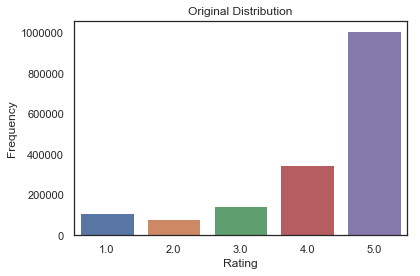

In [43]:
# create a bar graph that shows original distribution across rating buckets 
sns.set(style='white')
ax=sns.countplot(x='overall', data=df)

ax.set(xlabel='Rating', ylabel='Frequency')
ax.set(title='Original Distribution')
plt.tight_layout()
plt.savefig('class_imbalance',dpi=500)

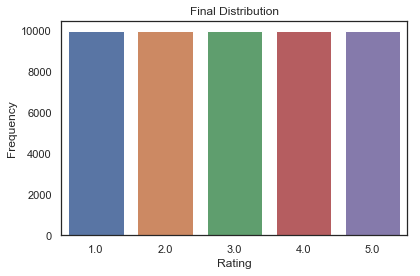

In [44]:
# create a bar graph that shows new distribution across rating buckets after adjusting for class imbalance
sns.set(style='white')
ax=sns.countplot(x='overall', data=df_final)

ax.set(xlabel='Rating', ylabel='Frequency')
ax.set(title='Final Distribution')
plt.tight_layout()
plt.savefig('class_imbalance_fixed',dpi=500)

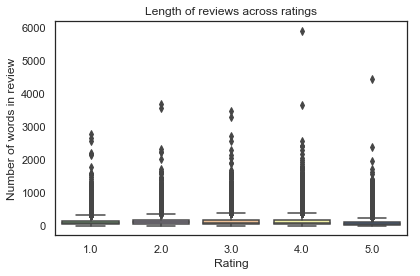

In [45]:
# create boxplot to visualize word count across rating buckets
ax = sns.boxplot(x='overall',y='word_count',data=df_engineered, palette='Accent')
ax.set(title='Length of reviews across ratings')
ax.set(xlabel='Rating',ylabel='Number of words in review')
plt.tight_layout()
# plt.savefig()

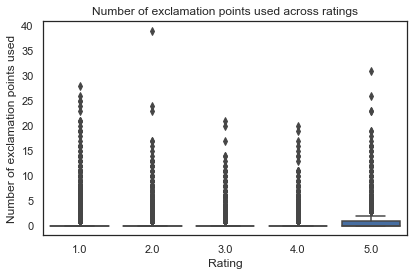

In [46]:
# create boxplot to visualize number of exclamation points across rating buckets
ax = sns.boxplot(x='overall',y='exclamation_count',data=df_engineered, palette='Accent')
ax.set(title='Number of exclamation points used across ratings')
ax.set(xlabel='Rating',ylabel='Number of exclamation points used')
plt.tight_layout()

## Exploring top words

In [63]:
# Let's look at the top n-grams
def get_top_n_grams(corpus, range_start, range_end, title, xlabel, ylabel, n=None):
    """
    List the top n words (or n-grams) in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer(ngram_range=(range_start,range_end)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    df = pd.DataFrame(words_freq[:n])
    
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=0,y=1, data=df)
    ax.set(title=title)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    plt.tight_layout()
    plt.savefig(title)

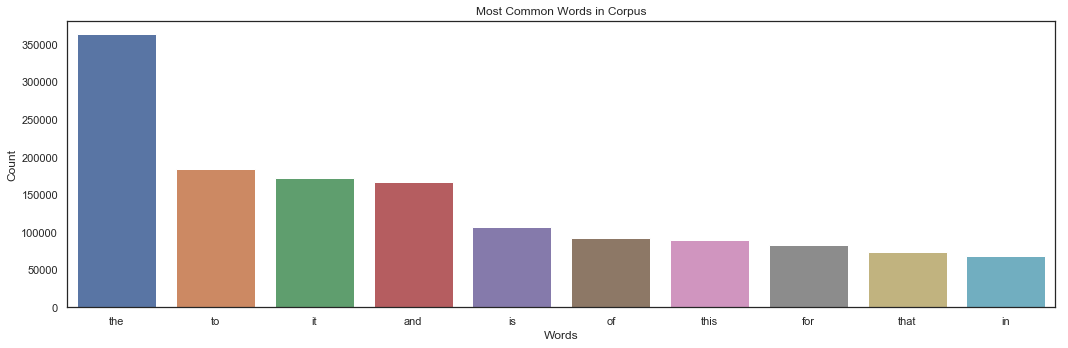

In [64]:
# find top words before removing stop words
get_top_n_grams(df_final['reviewText'],range_start=1,range_end=1, n=10, 
                title='Most Common Words in Corpus',xlabel='Words',ylabel='Count')

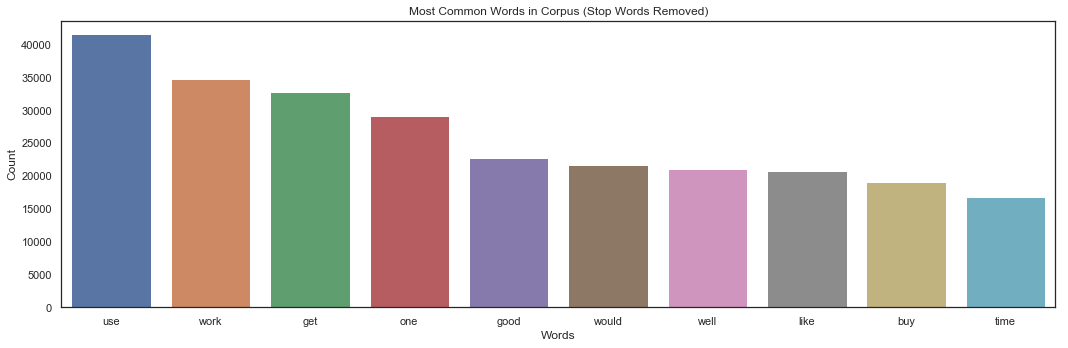

In [65]:
# find top words after removing stop words
get_top_n_grams(df_reviews_final['cleaned'],range_start=1,range_end=1, n=10, 
                title='Most Common Words in Corpus (Stop Words Removed)',xlabel='Words',ylabel='Count')

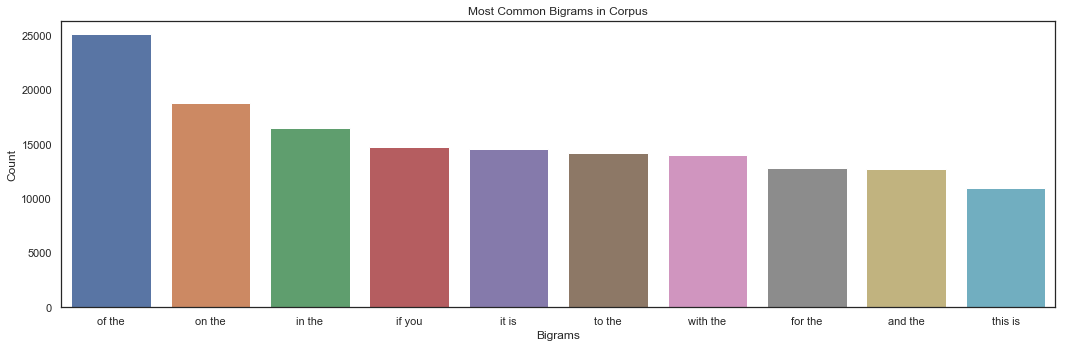

In [66]:
# top bigrams before removing stop words
get_top_n_grams(df_final['reviewText'],range_start=2,range_end=2, n=10, 
                title='Most Common Bigrams in Corpus',xlabel='Bigrams',ylabel='Count')

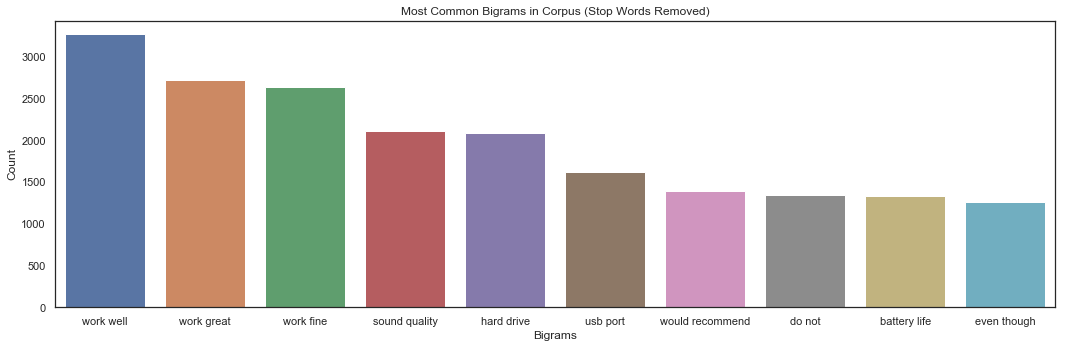

In [67]:
# find top bigrams after removing stop words
get_top_n_grams(df_reviews_final['cleaned'],range_start=2,range_end=2, n=10, 
                title='Most Common Bigrams in Corpus (Stop Words Removed)',xlabel='Bigrams',ylabel='Count')